# 1. Import Dataset and Load necessary packages

Here, loading dataset "Global Data on Sustainable Energy (2000-2020)".

This dataset contains energy indicators and the other useful factors across all countries from 2000 to 2020.

In this colab environment, you need to upload dataset file from your local computer.

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from google.colab import files

# Check for stationarity using Augmented Dickey-Fuller Test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# upload data from your disk driver
uploaded = files.upload()

Saving global-data-on-sustainable-energy.csv to global-data-on-sustainable-energy.csv


# 2. Data Pre-Processing.

Next step is data-preprocessing.

Here, we have to select necessary data and pre-process it to perform forecasting.

In [2]:
# read csv data from the colab driver
df = pd.read_csv(io.BytesIO(uploaded['global-data-on-sustainable-energy.csv']))

target = [
    'Primary energy consumption per capita (kWh/person)',
    'Value_co2_emissions_kt_by_country']

# select two necessary columns
energy_data = np.array(df[target])

# get data of first 3 countries
country_0 = energy_data[:20]
country_1 = energy_data[21:41]
country_2 = energy_data[42:62]

# get detail data
energy_0, co2_0 = country_0[:, 0], country_0[:, 1]
energy_1, co2_1 = country_1[:, 0], country_1[:, 1]
energy_2, co2_2 = country_2[:, 0], country_2[:, 1]

# 3. Model Selection.

Normally in data science, it is necessary to select several models and compare their performances.

But here, total amount of data is only 20, so selecting complex model can't solve the problem.

So, ARIMA is only selected.

ARIMA stands for AutoRegressive Integrated Moving Average.

It is a popular time series forecasting model that combines autoregression, differencing, and moving averages. ARIMA models are widely used for analyzing and forecasting time series data.

It is also combined model so, more efficient than using AR(AutoRegression) model and MA(Moving Average) individually.

3.1 First Country(Afghanistan)

As a first country, Afghanistan is selected.

First step of ARIMA is to check the current time series is stationary.

To check this, ADF test is released.


ADF stands for Augmented Dickey-Fuller (ADF) test. The ADF test is a statistical test that checks for the presence of a unit root in a univariate time series. If the time series has a unit root, it is non-stationary; otherwise, it is stationary.

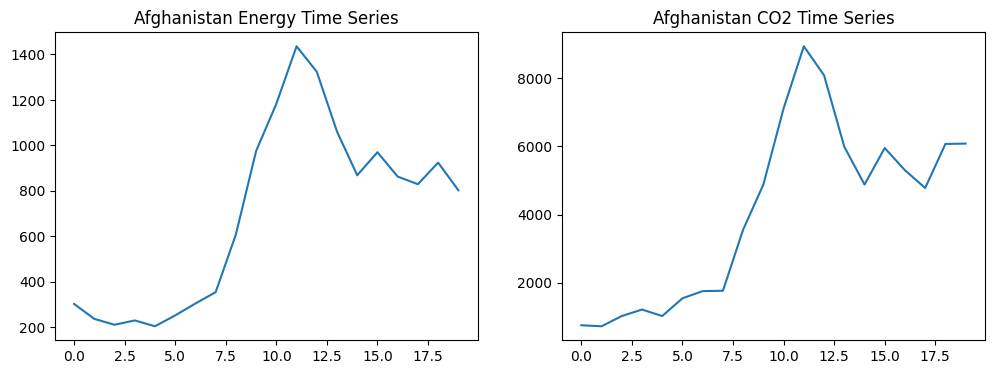

energy: 
ADF Statistic: 0.5794823910079371
p-value: 0.98709883439254
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
co2: 
ADF Statistic: -1.6871410674361633
p-value: 0.4377496665186311
Critical Values: {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}


In [3]:
# Plot the time series data
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(energy_0)
plt.title('Afghanistan Energy Time Series')

plt.subplot(1, 2, 2)
plt.plot(co2_0)
plt.title('Afghanistan CO2 Time Series')
plt.show()

print("energy: ")
adf_test(energy_0)

print("co2: ")
adf_test(co2_0)

As you can see, both of p-values are over than 5% so we need to differentiate the time series to make them stationary.

energy : 
ADF Statistic: -3.095067337985919
p-value: 0.026920387672238293
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
co2: 
ADF Statistic: -3.095067337985919
p-value: 0.026920387672238293
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}


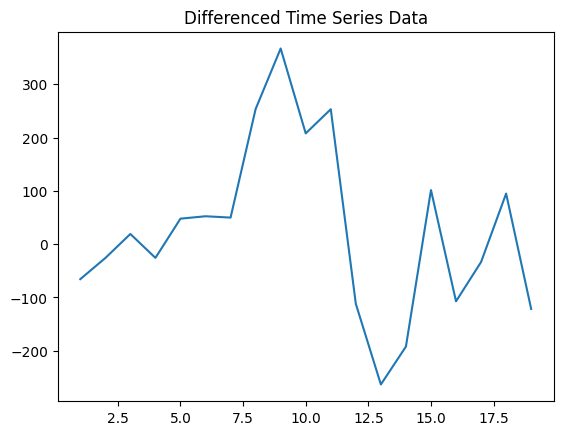

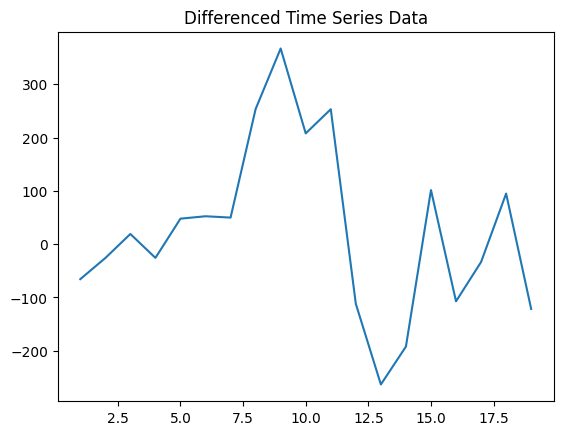

In [4]:
# Differencing to achieve stationarity
energy_0_diff = pd.DataFrame(energy_0).diff().dropna()
print("energy : ")
adf_test(energy_0_diff)

# Differencing to achieve stationarity
co2_0_diff = pd.DataFrame(energy_0).diff().dropna()
print("co2: ")
adf_test(co2_0_diff)

# Plot differenced time series
plt.plot(energy_0_diff)
plt.title('Differenced Time Series Data')
plt.show()

# Plot differenced time series
plt.plot(co2_0_diff)
plt.title('Differenced Time Series Data')
plt.show()

These two series become stationary after first differentiation.

Then, Let's set the p, q in ARIMA models.

To dertermine p and q values in ARIMA, we have to check ACF(Auto Correlation Function) and PACF(Partial Auto Correlation Function).

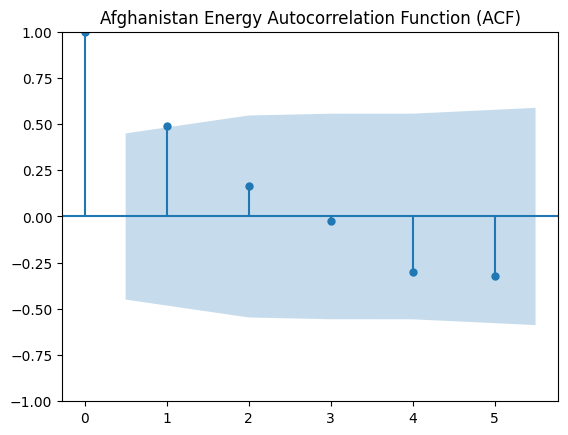

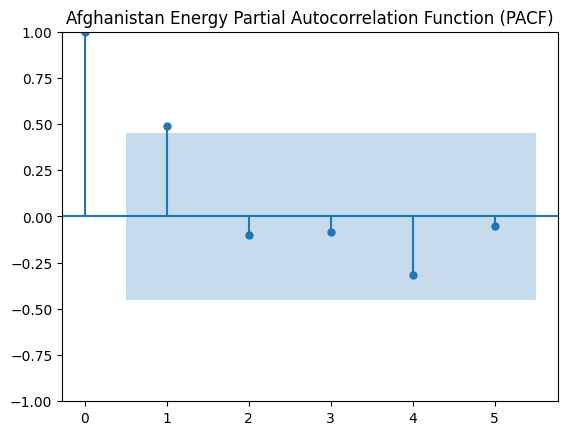

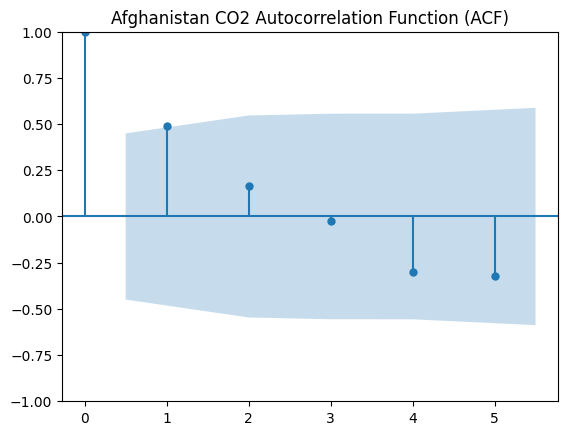

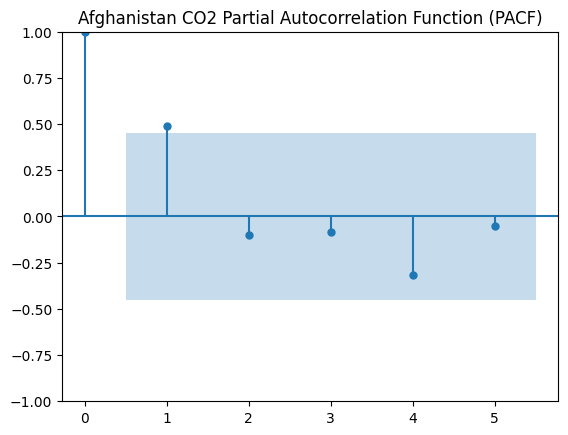

In [5]:
# ACF and PACF plots to determine p and q values
plot_acf(energy_0_diff, lags=5)
plt.title('Afghanistan Energy Autocorrelation Function (ACF)')
plt.show()

plot_pacf(energy_0_diff, lags=5)
plt.title('Afghanistan Energy Partial Autocorrelation Function (PACF)')
plt.show()

# ACF and PACF plots to determine p and q values
plot_acf(co2_0_diff, lags=5)
plt.title('Afghanistan CO2 Autocorrelation Function (ACF)')
plt.show()

plot_pacf(co2_0_diff, lags=5)
plt.title('Afghanistan CO2 Partial Autocorrelation Function (PACF)')
plt.show()

In ACF plot, look for where the ACF plot crosses the upper confidence interval for the first time.
The lag value at this point gives you an estimate of the autoregressive order p.

In PACF plot, look for where the PACF plot crosses the upper confidence interval for the first time.
The lag value at this point gives you an estimate of the moving average order q.

As you can see in these plots, in both of series, p = 3, q = 2.

So, we finally determined the parameters of ARIMA and can complete the model.

Below figures show test result.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


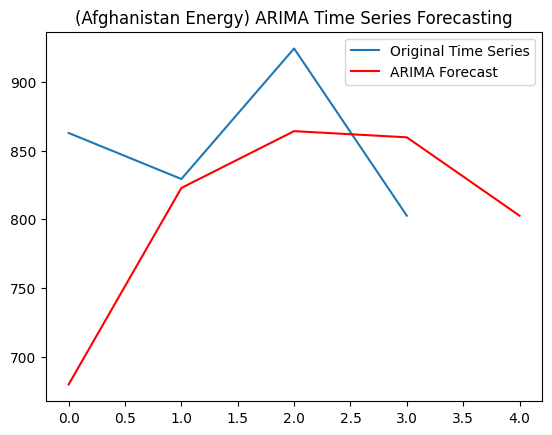

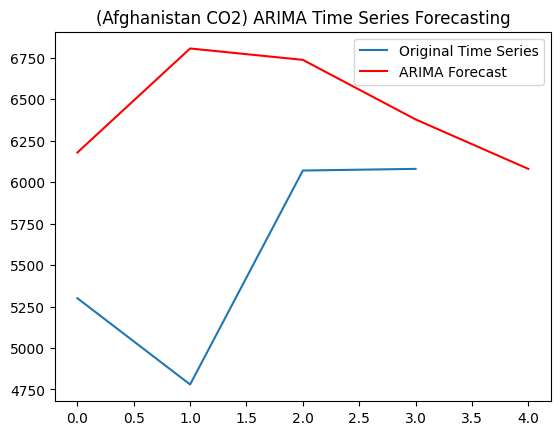

In [6]:
# ARIMA
p, q = 3, 2
model_energy_0 = ARIMA(energy_0[:16], order=(p, 1, q))
model_energy_0_result = model_energy_0.fit()
energy_0_forecast = model_energy_0_result.forecast(steps=5)
energy_0_forecast += energy_0[-1] - energy_0_forecast[-1]

model_co2_0 = ARIMA(co2_0[:16], order=(p, 1, q))
model_co2_0_result = model_co2_0.fit()
co2_0_forecast = model_co2_0_result.forecast(steps=5)
co2_0_forecast += co2_0[-1] - co2_0_forecast[-1]

# Plot0ing
plt.plot(energy_0[16:], label='Original Time Series')
plt.plot(energy_0_forecast, label='ARIMA Forecast', color='red')
plt.title('(Afghanistan Energy) ARIMA Time Series Forecasting')
plt.legend()
plt.show()

plt.plot(co2_0[16:], label='Original Time Series')
plt.plot(co2_0_forecast, label='ARIMA Forecast', color='red')
plt.title('(Afghanistan CO2) ARIMA Time Series Forecasting')
plt.legend()
plt.show()


This is the result of ARIMA forecasting for the first country.

3.2 Other Countries.(Albania, Algeria)

As the first counrty, we can forecast the energy and co2 values for these two countries.
Algorithm is same, so comment is skipped.

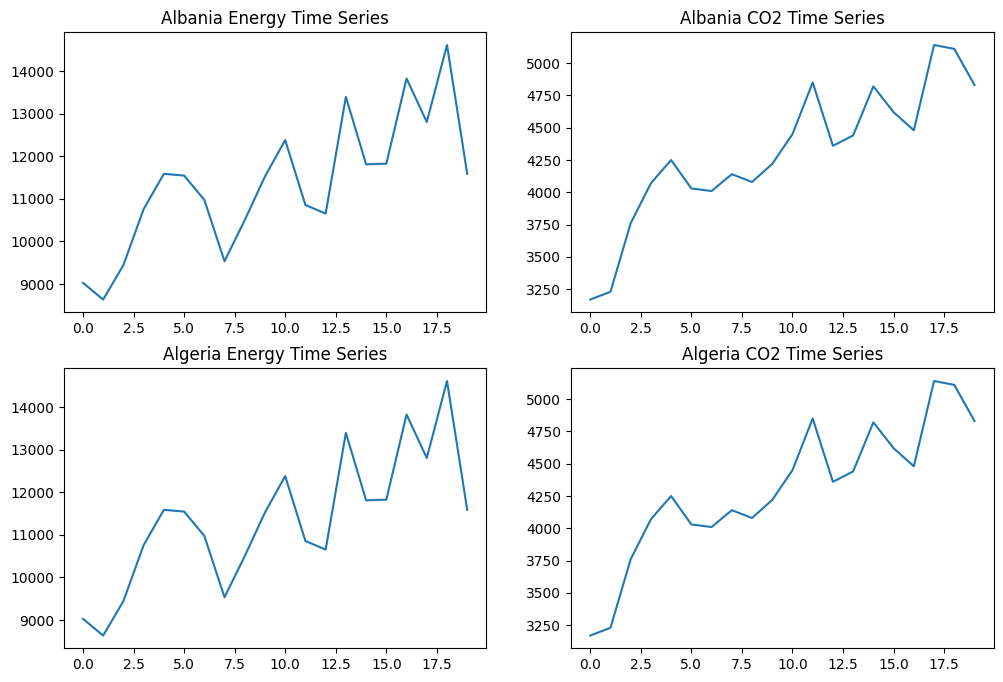

energy: 
ADF Statistic: 1.962369485077987
p-value: 0.9986220129451445
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
co2: 
ADF Statistic: -1.019916183779817
p-value: 0.7459312028505504
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
energy: 
ADF Statistic: 1.5703693588722836
p-value: 0.9977659017173242
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
co2: 
ADF Statistic: 1.327563983140628
p-value: 0.9967588961272618
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}


In [7]:
# Plot the time series data
plt.figure(figsize = (12, 8))
plt.subplot(2, 2, 1)
plt.plot(energy_1)
plt.title('Albania Energy Time Series')

plt.subplot(2, 2, 2)
plt.plot(co2_1)
plt.title('Albania CO2 Time Series')

plt.subplot(2, 2, 3)
plt.plot(energy_1)
plt.title('Algeria Energy Time Series')

plt.subplot(2, 2, 4)
plt.plot(co2_1)
plt.title('Algeria CO2 Time Series')

plt.show()

print("energy: ")
adf_test(energy_1)

print("co2: ")
adf_test(co2_1)

print("energy: ")
adf_test(energy_2)

print("co2: ")
adf_test(co2_2)

Also differentiate the series.

In [8]:
# Differencing to achieve stationarity
energy_1_diff = pd.DataFrame(energy_1).diff().dropna()
print("albania energy: ")
adf_test(energy_1_diff)

# Differencing to achieve stationarity
co2_1_diff = pd.DataFrame(energy_1).diff().dropna()
print("albania co2: ")
adf_test(co2_1_diff)

# Differencing to achieve stationarity
energy_2_diff = pd.DataFrame(energy_2).diff().dropna()
print("algeria energy: ")
adf_test(energy_2_diff)

# Differencing to achieve stationarity
co2_2_diff = pd.DataFrame(energy_2).diff().dropna()
print("algeria co2: ")
adf_test(co2_2_diff)

albania energy: 
ADF Statistic: -0.26824085944837595
p-value: 0.9298834891967553
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
albania co2: 
ADF Statistic: -0.26824085944837595
p-value: 0.9298834891967553
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
algeria energy: 
ADF Statistic: -3.9347867758366735
p-value: 0.0017932398212225857
Critical Values: {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}
algeria co2: 
ADF Statistic: -3.9347867758366735
p-value: 0.0017932398212225857
Critical Values: {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}


Determine p and q for ARIMA through ACF and PACF.

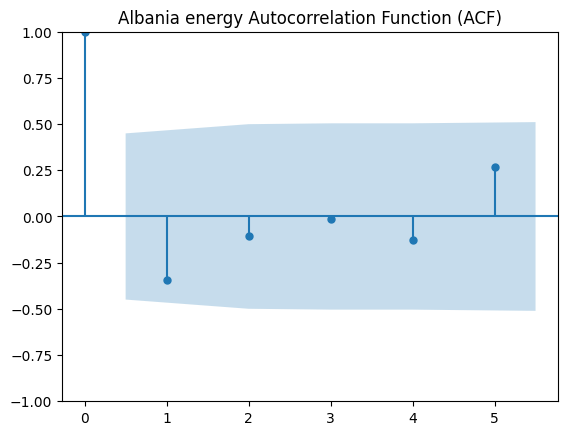

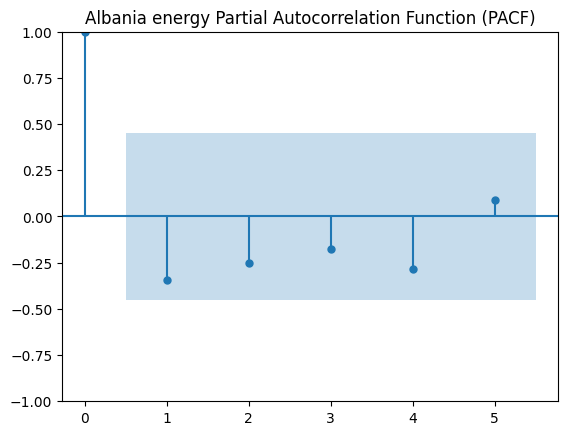

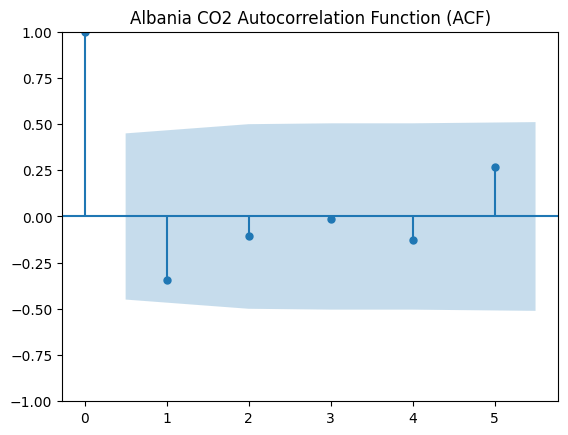

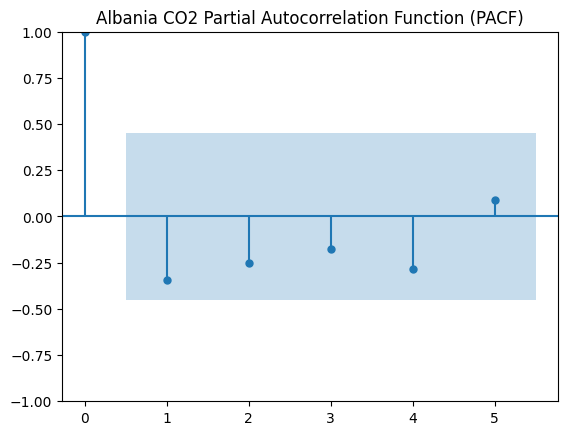

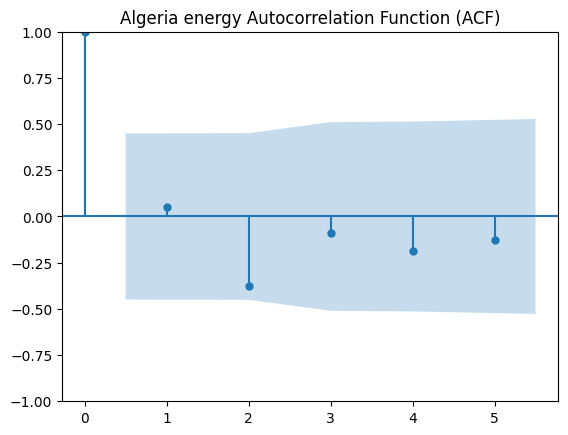

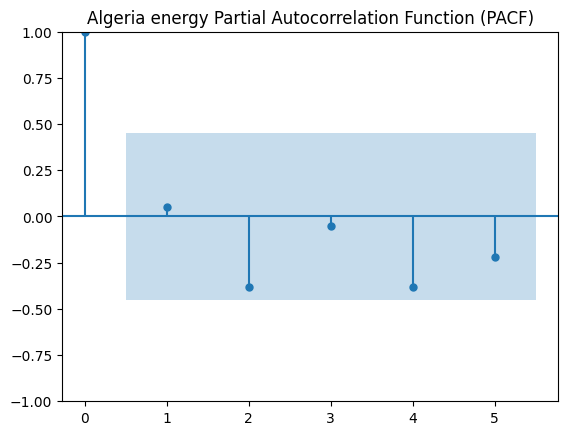

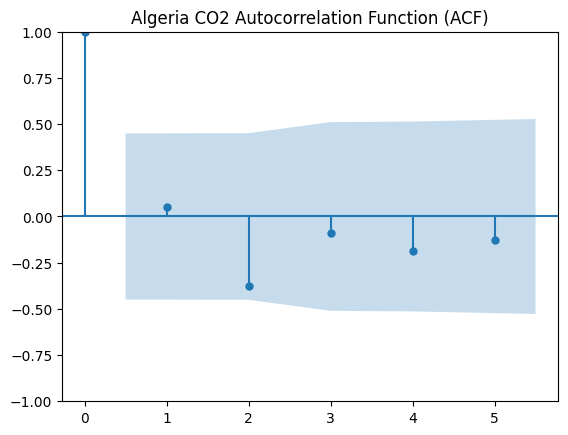

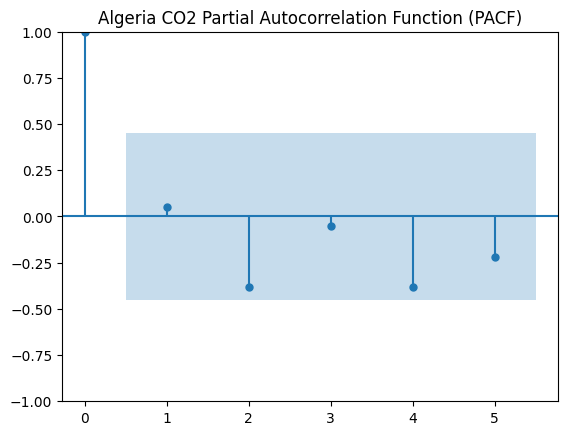

In [9]:
# ACF and PACF plots to determine p and q values
plot_acf(energy_1_diff, lags=5)
plt.title('Albania energy Autocorrelation Function (ACF)')
plt.show()

plot_pacf(energy_1_diff, lags=5)
plt.title('Albania energy Partial Autocorrelation Function (PACF)')
plt.show()

# ACF and PACF plots to determine p and q values
plot_acf(co2_1_diff, lags=5)
plt.title('Albania CO2 Autocorrelation Function (ACF)')
plt.show()

plot_pacf(co2_1_diff, lags=5)
plt.title('Albania CO2 Partial Autocorrelation Function (PACF)')
plt.show()

# ACF and PACF plots to determine p and q values
plot_acf(energy_2_diff, lags=5)
plt.title('Algeria energy Autocorrelation Function (ACF)')
plt.show()

plot_pacf(energy_2_diff, lags=5)
plt.title('Algeria energy Partial Autocorrelation Function (PACF)')
plt.show()

# ACF and PACF plots to determine p and q values
plot_acf(co2_2_diff, lags=5)
plt.title('Algeria CO2 Autocorrelation Function (ACF)')
plt.show()

plot_pacf(co2_2_diff, lags=5)
plt.title('Algeria CO2 Partial Autocorrelation Function (PACF)')
plt.show()

Fit models and show test results.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


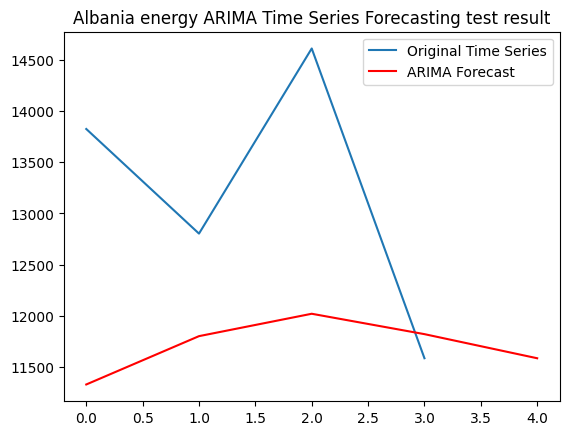

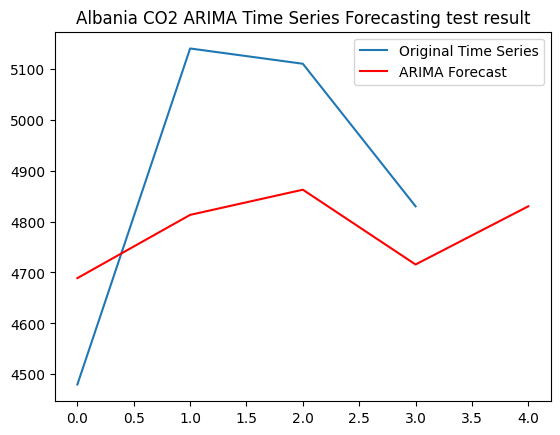

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


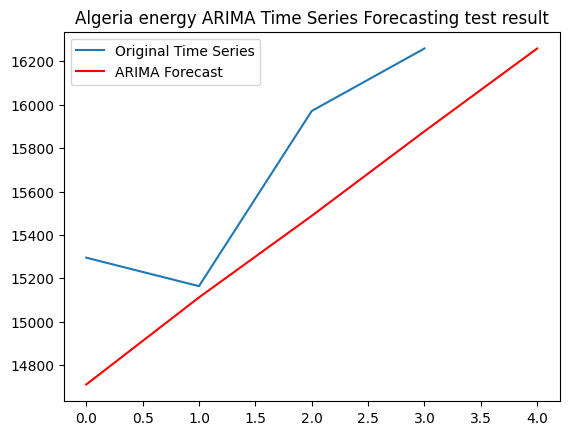

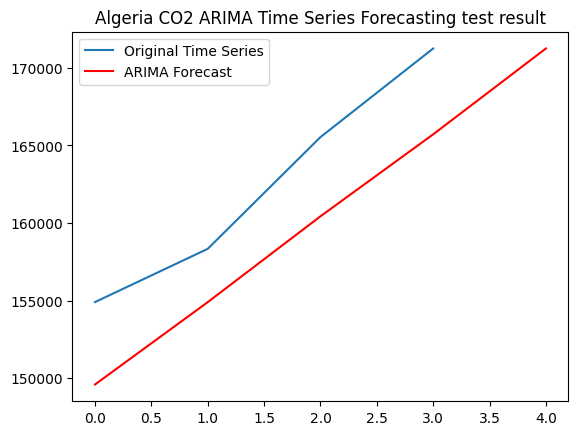

In [10]:
# ARIMA
model_energy_1 = ARIMA(energy_1[:16], order=(3, 1, 2))
model_energy_1_result = model_energy_1.fit()
energy_1_forecast = model_energy_1_result.forecast(steps=5)
energy_1_forecast += energy_1[-1] - energy_1_forecast[-1]

model_co2_1 = ARIMA(co2_1[:16], order=(3, 1, 2))
model_co2_1_result = model_co2_1.fit()
co2_1_forecast = model_co2_1_result.forecast(steps=5)
co2_1_forecast += co2_1[-1] - co2_1_forecast[-1]

# Plot0ing
plt.plot(energy_1[16:], label='Original Time Series')
plt.plot(energy_1_forecast, label='ARIMA Forecast', color='red')
plt.title('Albania energy ARIMA Time Series Forecasting test result')
plt.legend()
plt.show()

plt.plot(co2_1[16:], label='Original Time Series')
plt.plot(co2_1_forecast, label='ARIMA Forecast', color='red')
plt.title('Albania CO2 ARIMA Time Series Forecasting test result')
plt.legend()
plt.show()

# ARIMA
model_energy_2 = ARIMA(energy_2[:16], order=(3, 1, 2))
model_energy_2_result = model_energy_2.fit()
energy_2_forecast = model_energy_2_result.forecast(steps=5)
energy_2_forecast += energy_2[-1] - energy_2_forecast[-1]

model_co2_2 = ARIMA(co2_2[:16], order=(3, 1, 2))
model_co2_2_result = model_co2_2.fit()
co2_2_forecast = model_co2_2_result.forecast(steps=5)
co2_2_forecast += co2_2[-1] - co2_2_forecast[-1]

# Plot0ing
plt.plot(energy_2[16:], label='Original Time Series')
plt.plot(energy_2_forecast, label='ARIMA Forecast', color='red')
plt.title('Algeria energy ARIMA Time Series Forecasting test result')
plt.legend()
plt.show()

plt.plot(co2_2[16:], label='Original Time Series')
plt.plot(co2_2_forecast, label='ARIMA Forecast', color='red')
plt.title('Algeria CO2 ARIMA Time Series Forecasting test result')
plt.legend()
plt.show()

# 4. Predict and Forecast for next 5 years.

In previous sections, we determined the parameters of ARIMA models.

And we only neet to forecast next 5 years result.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Afghanistan energy: 
2021: 802.612550
2022: 819.142852
2023: 854.100944
2024: 857.460032
2025: 830.490706
Afghanistan co2: 
2021: 6079.999924
2022: 6120.654052
2023: 6087.065827
2024: 6084.544519
2025: 6076.908657


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


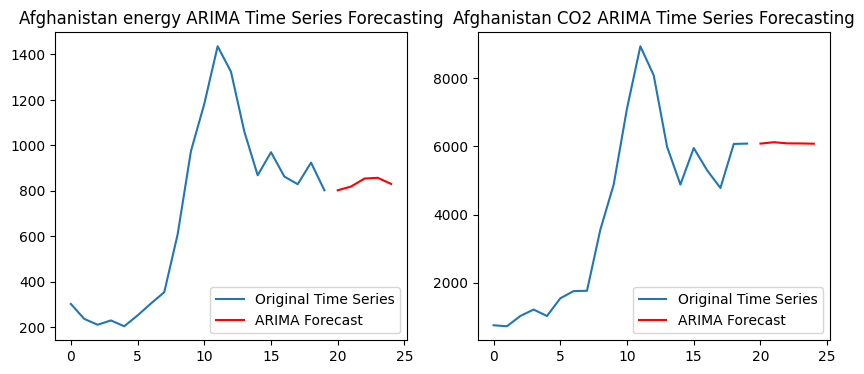

In [15]:
# ARIMA
model_energy_0 = ARIMA(energy_0, order=(3, 1, 2))
model_energy_0_result = model_energy_0.fit()
energy_0_forecast = model_energy_0_result.forecast(steps=5)
energy_0_forecast += energy_0[-1] - energy_0_forecast[0]
print("Afghanistan energy: ")
for i in range(np.shape(energy_0_forecast)[0]):
  print("%d: %lf" % (i + 2021, energy_0_forecast[i]))

model_co2_0 = ARIMA(co2_0, order=(3, 1, 2))
model_co2_0_result = model_co2_0.fit()
co2_0_forecast = model_co2_0_result.forecast(steps=5)
co2_0_forecast += co2_0[-1] - co2_0_forecast[0]
print("Afghanistan co2: ")
for i in range(np.shape(co2_0_forecast)[0]):
  print("%d: %lf" % (i + 2021, co2_0_forecast[i]))

# Plot0ing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, np.shape(energy_0)[0]), energy_0, label='Original Time Series')
plt.plot(np.arange(np.shape(energy_0)[0], np.shape(energy_0)[0] + 5), energy_0_forecast, label='ARIMA Forecast', color='red')
plt.title('Afghanistan energy ARIMA Time Series Forecasting')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, np.shape(co2_0)[0]), co2_0, label='Original Time Series')
plt.plot(np.arange(np.shape(co2_0)[0], np.shape(co2_0)[0] + 5), co2_0_forecast, label='ARIMA Forecast', color='red')
plt.title('Afghanistan CO2 ARIMA Time Series Forecasting')
plt.legend()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Albania energy: 
2021: 11585.555000
2022: 11794.328054
2023: 11471.906295
2024: 11733.132129
2025: 11618.972047
Albania co2: 
2021: 4829.999924
2022: 5040.426775
2023: 4754.850671
2024: 4713.445687
2025: 5003.545013


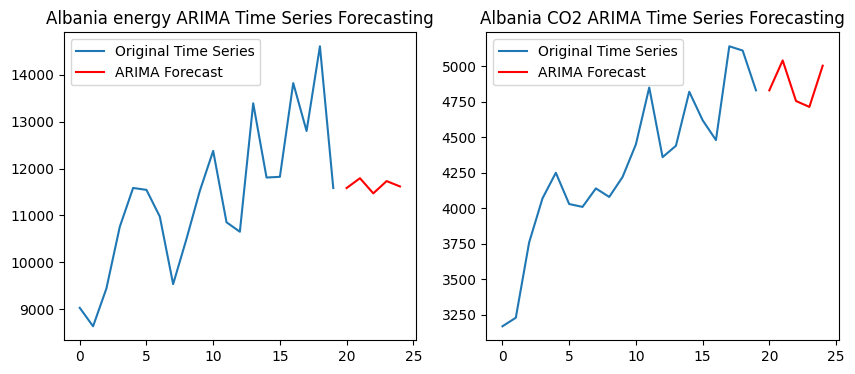

In [16]:
# ARIMA
model_energy_1 = ARIMA(energy_1, order=(3, 1, 2))
model_energy_1_result = model_energy_1.fit()
energy_1_forecast = model_energy_1_result.forecast(steps=5)
energy_1_forecast += energy_1[-1] - energy_1_forecast[0]
print("Albania energy: ")
for i in range(np.shape(energy_1_forecast)[0]):
  print("%d: %lf" % (i + 2021, energy_1_forecast[i]))

model_co2_1 = ARIMA(co2_1, order=(3, 1, 2))
model_co2_1_result = model_co2_1.fit()
co2_1_forecast = model_co2_1_result.forecast(steps=5)
co2_1_forecast += co2_1[-1] - co2_1_forecast[0]
print("Albania co2: ")
for i in range(np.shape(co2_1_forecast)[0]):
  print("%d: %lf" % (i + 2021, co2_1_forecast[i]))

# Plot0ing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, np.shape(energy_1)[0]), energy_1, label='Original Time Series')
plt.plot(np.arange(np.shape(energy_1)[0], np.shape(energy_1)[0] + 5), energy_1_forecast, label='ARIMA Forecast', color='red')
plt.title('Albania energy ARIMA Time Series Forecasting')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, np.shape(co2_1)[0]), co2_1, label='Original Time Series')
plt.plot(np.arange(np.shape(co2_1)[0], np.shape(co2_1)[0] + 5), co2_1_forecast, label='ARIMA Forecast', color='red')
plt.title('Albania CO2 ARIMA Time Series Forecasting')
plt.legend()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Algeria energy: 
2021: 16259.053000
2022: 16671.398167
2023: 17065.815801
2024: 17443.599086
2025: 17815.196539
Algeria co2: 
2021: 171250.000000
2022: 176375.237860
2023: 181491.706298
2024: 186596.640535
2025: 191700.882398


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


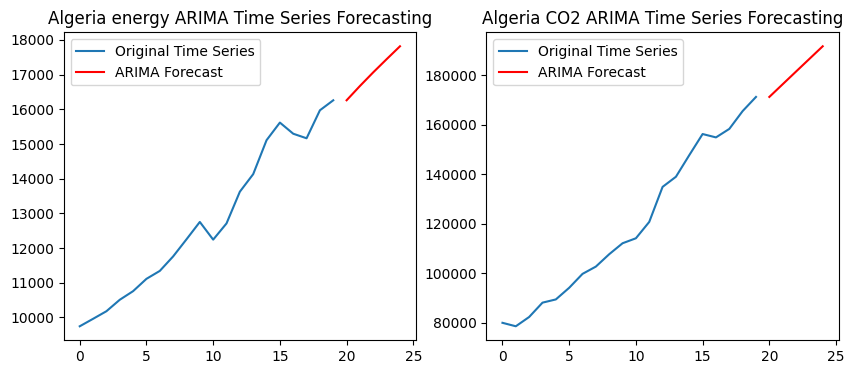

In [17]:
# ARIMA
model_energy_2 = ARIMA(energy_2, order=(3, 1, 2))
model_energy_2_result = model_energy_2.fit()
energy_2_forecast = model_energy_2_result.forecast(steps=5)
energy_2_forecast += energy_2[-1] - energy_2_forecast[0]
print("Algeria energy: ")
for i in range(np.shape(energy_2_forecast)[0]):
  print("%d: %lf" % (i + 2021, energy_2_forecast[i]))

model_co2_2 = ARIMA(co2_2, order=(3, 1, 2))
model_co2_2_result = model_co2_2.fit()
co2_2_forecast = model_co2_2_result.forecast(steps=5)
co2_2_forecast += co2_2[-1] - co2_2_forecast[0]
print("Algeria co2: ")
for i in range(np.shape(co2_2_forecast)[0]):
  print("%d: %lf" % (i + 2021, co2_2_forecast[i]))

# Plot0ing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, np.shape(energy_2)[0]), energy_2, label='Original Time Series')
plt.plot(np.arange(np.shape(energy_2)[0], np.shape(energy_2)[0] + 5), energy_2_forecast, label='ARIMA Forecast', color='red')
plt.title('Algeria energy ARIMA Time Series Forecasting')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, np.shape(co2_2)[0]), co2_2, label='Original Time Series')
plt.plot(np.arange(np.shape(co2_2)[0], np.shape(co2_2)[0] + 5), co2_2_forecast, label='ARIMA Forecast', color='red')
plt.title('Algeria CO2 ARIMA Time Series Forecasting')
plt.legend()